In [1]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import torchaudio.transforms as T
import torchvision.models as models
import torch.optim.lr_scheduler as lr_scheduler
import pandas as pd
import torch.nn as nn
from tqdm import tqdm
import datetime
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import timm
from torch.profiler import profile, record_function, ProfilerActivity

#Global Parameters and Variables loaded 
import config

if config.ADSMI:
    from DL_pretrain import ADSMI_DL_NP_petrain as DL
    Data_name = 'ADSMI'

# clear cuda cache
torch.cuda.empty_cache()

In [2]:
## Loss Function: Triplet Contrtastive Loss function 

In [3]:

class ContrastiveTripletLoss(nn.Module):
    def __init__(self, margin=0.5, temperature=0.07):
        super(ContrastiveTripletLoss, self).__init__()
        self.margin = margin
        self.temperature = temperature

    def forward(self, anchor, positive, negative):
        """
        Args:
        - anchor: Embeddings from log_s_po_aug1
        - positive: Embeddings from log_s_po_aug2
        - negative: Embeddings from log_s_neg_aug1

        Returns:
        - A loss scalar.
        """
        # L2 normalize the embeddings
        anchor = F.normalize(anchor, p=2, dim=1)
        positive = F.normalize(positive, p=2, dim=1)
        negative = F.normalize(negative, p=2, dim=1)

        # Compute similarities
        pos_sim = F.cosine_similarity(anchor, positive) / self.temperature
        neg_sim = F.cosine_similarity(anchor, negative) / self.temperature

        # Compute the triplet loss
        losses = F.relu(self.margin - pos_sim + neg_sim)

        return losses.mean()
    


# Model with PH

In [4]:
print(config.channels)

class ContrastiveTripletModelwithPH(nn.Module):
    def __init__(self, embedding_dim=2048, projection_dim=128):
        super(ContrastiveTripletModelwithPH, self).__init__()
        self.resnet50 = models.resnet50(pretrained=False)
        
        self.resnet50.conv1 = nn.Conv2d(config.channels, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        
        # Remove last FC layer to get embeddings
        self.encoder = nn.Sequential(*list(self.resnet50.children())[:-1])
        
        # Projection head
        self.projection = nn.Sequential(
            nn.Linear(embedding_dim, embedding_dim),  # 1st projection layer
            nn.ReLU(),
            nn.Linear(embedding_dim, projection_dim)  # 2nd projection layer
        )
        
        # Dropout layer 
        self.dropout = nn.Dropout(p=0.5)

    def forward_one(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  
        x = self.projection(x)  
        x = self.dropout(x)
        return x

    def forward(self, input1, input2, input3):
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        output3 = self.forward_one(input3)
        return output1, output2, output3
    
class ContrastiveTripletModel(nn.Module):
    def __init__(self):
        super(ContrastiveTripletModel, self).__init__()
        self.resnet50 = models.resnet50(pretrained=False)
        
        # Modifications for your dataset:
        self.resnet50.conv1 = nn.Conv2d(config.channels, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        
        # Remove last FC layer to get embeddings
        self.encoder = nn.Sequential(*list(self.resnet50.children())[:-1])

    def forward_one(self, x):
        #print(f"Shape of x before unsqueeze: {x.shape}") 
        x = self.encoder(x)
        x = x.view(x.size(0), -1) # Flatten for easier downstream processing
        return x

    def forward(self, input1, input2, input3):
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        output3 = self.forward_one(input3)
        return output1, output2, output3

class ContrastiveTripletModelwithPHEfficient(nn.Module):
    def __init__(self, embedding_dim=1280, projection_dim=128, efficientnet_version='efficientnet_b0'):
        super(ContrastiveTripletModelwithPHEfficient, self).__init__()

        # Load a pre-trained EfficientNet. 
        self.efficientnet = timm.create_model(efficientnet_version, pretrained=False, features_only=True)

        # Calculate the feature dimension of EfficientNet
        feature_dim = self.efficientnet.feature_info.channels()[-1]
        
        # Projection head
        self.projection = nn.Sequential(
            nn.Linear(feature_dim, embedding_dim),  # 1st projection layer, can be modified
            nn.ReLU(),
            nn.Linear(embedding_dim, projection_dim)  # 2nd projection layer
        )
        # Dropout layer (if needed)
        self.dropout = nn.Dropout(p=0.5)

    def forward_one(self, x):
        x = self.efficientnet(x)[-1]  # Get the last set of features
        x = F.adaptive_avg_pool2d(x, 1).view(x.size(0), -1)  # Global Average Pooling and Flatten
        x = self.projection(x)  # Pass through the projection head
        #x = self.dropout(x)
        return x

    def forward(self, input1, input2, input3):
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        output3 = self.forward_one(input3)
        return output1, output2, output3

3


## Model initialization

In [5]:

patience = 35 
early_stop_counter = 0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(config.epochs)
print(config.batch_size)


# Initialization
#model = ContrastiveTripletModel().to(device)
model = ContrastiveTripletModelwithPH().to(device)
#model = ContrastiveTripletModelwithPHEfficient().to(device)
optimizer = optim.Adam(model.parameters(), lr=config.lr)
criterion = ContrastiveTripletLoss()

config.desired_length_in_seconds = 7
config.freq_mask_param = 25
config.time_mask_param = 80

# Data
train_loader, test_loader = DL.create_generators()



250
32


c:\Users\Gabriel\anaconda3\envs\pytorch\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Gabriel\anaconda3\envs\pytorch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Number of files:  39887
2013-10-18_16-03-42_01.WAV
Fullpath: G:/Dokumente/MAData/Unlabeled_all/2013-10-18_16-03-42_01.WAV
Number of files:  4431
2013-10-18_15-48-26_01.WAV
Fullpath: G:/Dokumente/MAData/Unlabeled_all/2013-10-18_15-48-26_01.WAV


## Plot of Pairs

Max Time shift 0.6 seconds
### Augumentions 
* Time masking
* Freq Masking
* Time Shift
* Vol perturbation
* additive noise


torch.Size([128, 438])
torch.Size([32, 3, 128, 438])


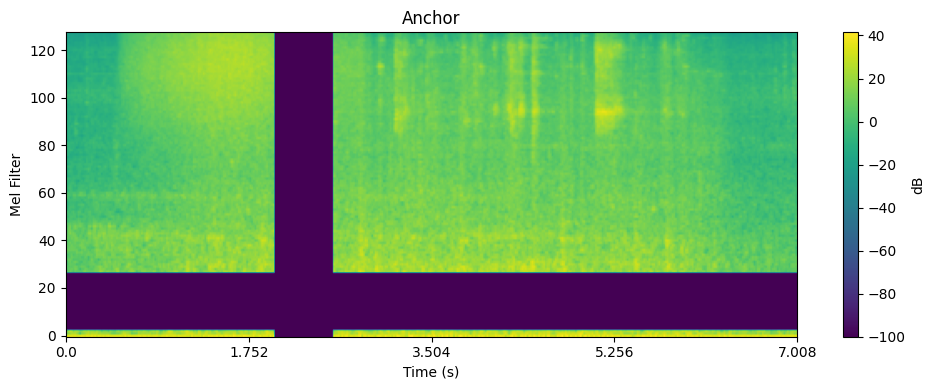

torch.Size([128, 438])
torch.Size([32, 3, 128, 438])


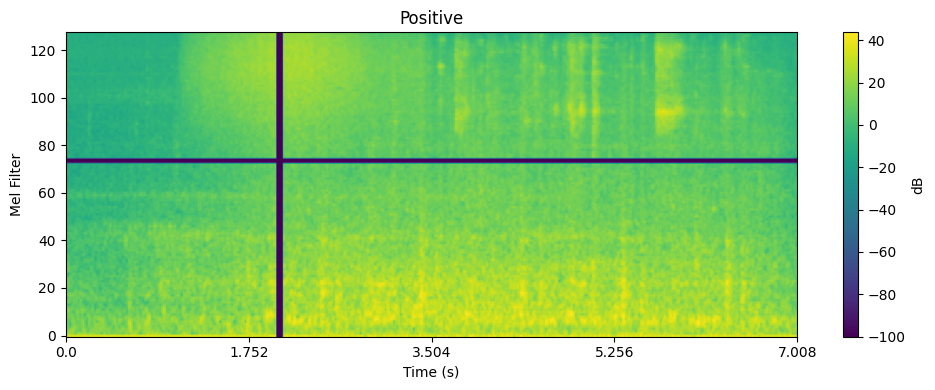

torch.Size([128, 438])
torch.Size([32, 3, 128, 438])


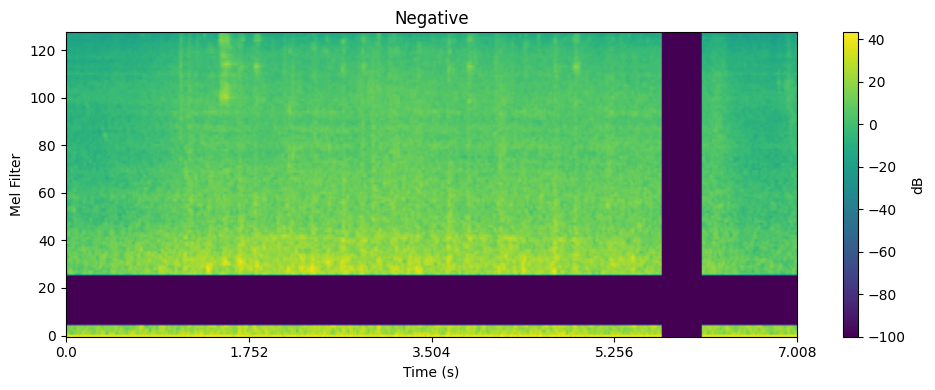

In [6]:
data1, data2, data3 = next(iter(train_loader))

def plot_mel_spectrogram(melspe_db, sample_rate, hop_length, name):
    plt.figure(figsize=(10, 4))

    melspe_db_single = melspe_db[0, 0, :, :].squeeze()

    print(melspe_db_single.shape)
    print(melspe_db.shape)

    if melspe_db_single.ndim != 2:
        raise ValueError("melspe_db_single should be a 2D array")

    # Convert tensor data to numpy for visualization
    melspe_db_np = melspe_db_single.cpu().detach().numpy()

    # Display the spectrogram
    plt.imshow(melspe_db_np, cmap='viridis', origin='lower', aspect='auto')
    plt.ylabel('Mel Filter')
    plt.xlabel('Time (s)')
    plt.colorbar(label='dB')
    plt.title(name)

    # Adjust x-axis to show time in seconds
    num_time_bins = melspe_db_np.shape[1]
    plt.xticks(np.linspace(0, num_time_bins, 5), 
               np.linspace(0, num_time_bins * hop_length / sample_rate, 5))

    plt.tight_layout()
    plt.show()

# Call the function with the modified data
plot_mel_spectrogram(data1, sample_rate=32000, hop_length=512,name="Anchor")
plot_mel_spectrogram(data2, sample_rate=32000, hop_length=512,name="Positive")
plot_mel_spectrogram(data3, sample_rate=32000, hop_length=512,name="Negative")




## Model init and Log file creation

100%|██████████| 139/139 [00:45<00:00,  3.07it/s]


Epoch [1/250] Training Loss: 0.5175, Validation Loss: 0.0503
Validation Loss improved! Checkpointing the model...


100%|██████████| 139/139 [00:45<00:00,  3.08it/s]


Epoch [2/250] Training Loss: 0.1561, Validation Loss: 0.0086
Validation Loss improved! Checkpointing the model...


100%|██████████| 139/139 [00:47<00:00,  2.93it/s]


Epoch [3/250] Training Loss: 0.1059, Validation Loss: 0.0082
Validation Loss improved! Checkpointing the model...


100%|██████████| 139/139 [00:45<00:00,  3.04it/s]


Epoch [4/250] Training Loss: 0.0991, Validation Loss: 0.0068
Validation Loss improved! Checkpointing the model...


100%|██████████| 139/139 [00:48<00:00,  2.87it/s]


Epoch [5/250] Training Loss: 0.0872, Validation Loss: 0.0042
Validation Loss improved! Checkpointing the model...


100%|██████████| 139/139 [00:46<00:00,  2.97it/s]


Epoch [6/250] Training Loss: 0.0765, Validation Loss: 0.0047


100%|██████████| 139/139 [00:49<00:00,  2.83it/s]


Epoch [7/250] Training Loss: 0.0665, Validation Loss: 0.0021
Validation Loss improved! Checkpointing the model...


100%|██████████| 139/139 [00:46<00:00,  2.96it/s]


Epoch [8/250] Training Loss: 0.0609, Validation Loss: 0.0022


100%|██████████| 139/139 [00:46<00:00,  2.98it/s]


Epoch [9/250] Training Loss: 0.0565, Validation Loss: 0.0027


100%|██████████| 139/139 [00:46<00:00,  2.98it/s]


Epoch [10/250] Training Loss: 0.0547, Validation Loss: 0.0023


100%|██████████| 139/139 [00:47<00:00,  2.91it/s]


Epoch [11/250] Training Loss: 0.0473, Validation Loss: 0.0020
Validation Loss improved! Checkpointing the model...


100%|██████████| 139/139 [00:51<00:00,  2.72it/s]


Epoch [12/250] Training Loss: 0.0486, Validation Loss: 0.0026


100%|██████████| 139/139 [00:45<00:00,  3.08it/s]


Epoch [13/250] Training Loss: 0.0465, Validation Loss: 0.0021


100%|██████████| 139/139 [00:46<00:00,  3.01it/s]


Epoch [14/250] Training Loss: 0.0418, Validation Loss: 0.0028


100%|██████████| 139/139 [00:43<00:00,  3.16it/s]


Epoch [15/250] Training Loss: 0.0427, Validation Loss: 0.0024


100%|██████████| 139/139 [00:43<00:00,  3.18it/s]


Epoch [16/250] Training Loss: 0.0399, Validation Loss: 0.0016
Validation Loss improved! Checkpointing the model...


100%|██████████| 139/139 [00:43<00:00,  3.16it/s]


Epoch [17/250] Training Loss: 0.0397, Validation Loss: 0.0018


100%|██████████| 139/139 [00:43<00:00,  3.19it/s]


Epoch [18/250] Training Loss: 0.0380, Validation Loss: 0.0010
Validation Loss improved! Checkpointing the model...


100%|██████████| 139/139 [00:43<00:00,  3.17it/s]


Epoch [19/250] Training Loss: 0.0347, Validation Loss: 0.0010
Validation Loss improved! Checkpointing the model...


100%|██████████| 139/139 [00:43<00:00,  3.17it/s]


Epoch [20/250] Training Loss: 0.0373, Validation Loss: 0.0016


100%|██████████| 139/139 [00:44<00:00,  3.15it/s]


Epoch [21/250] Training Loss: 0.0340, Validation Loss: 0.0012


100%|██████████| 139/139 [00:43<00:00,  3.17it/s]


Epoch [22/250] Training Loss: 0.0324, Validation Loss: 0.0017


100%|██████████| 139/139 [00:44<00:00,  3.14it/s]


Epoch [23/250] Training Loss: 0.0319, Validation Loss: 0.0017


100%|██████████| 139/139 [00:44<00:00,  3.14it/s]


Epoch [24/250] Training Loss: 0.0314, Validation Loss: 0.0007
Validation Loss improved! Checkpointing the model...


100%|██████████| 139/139 [00:46<00:00,  3.00it/s]


Epoch [25/250] Training Loss: 0.0326, Validation Loss: 0.0012


100%|██████████| 139/139 [00:43<00:00,  3.17it/s]


Epoch [26/250] Training Loss: 0.0293, Validation Loss: 0.0009


100%|██████████| 139/139 [00:48<00:00,  2.87it/s]


Epoch [27/250] Training Loss: 0.0296, Validation Loss: 0.0008


100%|██████████| 139/139 [00:48<00:00,  2.89it/s]


Epoch [28/250] Training Loss: 0.0303, Validation Loss: 0.0014


100%|██████████| 139/139 [00:47<00:00,  2.90it/s]


Epoch [29/250] Training Loss: 0.0281, Validation Loss: 0.0014


100%|██████████| 139/139 [00:46<00:00,  2.96it/s]


Epoch [30/250] Training Loss: 0.0277, Validation Loss: 0.0010


100%|██████████| 139/139 [00:46<00:00,  2.97it/s]


Epoch [31/250] Training Loss: 0.0264, Validation Loss: 0.0009


100%|██████████| 139/139 [00:47<00:00,  2.95it/s]


Epoch [32/250] Training Loss: 0.0277, Validation Loss: 0.0006
Validation Loss improved! Checkpointing the model...


100%|██████████| 139/139 [00:47<00:00,  2.91it/s]


Epoch [33/250] Training Loss: 0.0261, Validation Loss: 0.0006


100%|██████████| 139/139 [00:47<00:00,  2.92it/s]


Epoch [34/250] Training Loss: 0.0256, Validation Loss: 0.0011


100%|██████████| 139/139 [00:47<00:00,  2.92it/s]


Epoch [35/250] Training Loss: 0.0241, Validation Loss: 0.0008


100%|██████████| 139/139 [00:48<00:00,  2.88it/s]


Epoch [36/250] Training Loss: 0.0249, Validation Loss: 0.0009


100%|██████████| 139/139 [00:47<00:00,  2.90it/s]


Epoch [37/250] Training Loss: 0.0265, Validation Loss: 0.0005
Validation Loss improved! Checkpointing the model...


100%|██████████| 139/139 [00:47<00:00,  2.94it/s]


Epoch [38/250] Training Loss: 0.0250, Validation Loss: 0.0007


100%|██████████| 139/139 [00:46<00:00,  2.96it/s]


Epoch [39/250] Training Loss: 0.0237, Validation Loss: 0.0009


100%|██████████| 139/139 [00:46<00:00,  2.96it/s]


Epoch [40/250] Training Loss: 0.0238, Validation Loss: 0.0007


100%|██████████| 139/139 [00:47<00:00,  2.93it/s]


Epoch [41/250] Training Loss: 0.0237, Validation Loss: 0.0014


100%|██████████| 139/139 [00:47<00:00,  2.95it/s]


Epoch [42/250] Training Loss: 0.0229, Validation Loss: 0.0006


100%|██████████| 139/139 [00:47<00:00,  2.92it/s]


Epoch [43/250] Training Loss: 0.0238, Validation Loss: 0.0005
Validation Loss improved! Checkpointing the model...


100%|██████████| 139/139 [00:47<00:00,  2.93it/s]


Epoch [44/250] Training Loss: 0.0226, Validation Loss: 0.0005
Validation Loss improved! Checkpointing the model...


100%|██████████| 139/139 [00:47<00:00,  2.91it/s]


Epoch [45/250] Training Loss: 0.0234, Validation Loss: 0.0010


100%|██████████| 139/139 [00:47<00:00,  2.90it/s]


Epoch [46/250] Training Loss: 0.0235, Validation Loss: 0.0005


100%|██████████| 139/139 [00:47<00:00,  2.91it/s]


Epoch [47/250] Training Loss: 0.0194, Validation Loss: 0.0005


100%|██████████| 139/139 [00:47<00:00,  2.90it/s]


Epoch [48/250] Training Loss: 0.0232, Validation Loss: 0.0006


100%|██████████| 139/139 [00:46<00:00,  2.96it/s]


Epoch [49/250] Training Loss: 0.0219, Validation Loss: 0.0006


100%|██████████| 139/139 [00:47<00:00,  2.95it/s]


Epoch [50/250] Training Loss: 0.0221, Validation Loss: 0.0006


100%|██████████| 139/139 [00:47<00:00,  2.94it/s]


Epoch [51/250] Training Loss: 0.0201, Validation Loss: 0.0001
Validation Loss improved! Checkpointing the model...


100%|██████████| 139/139 [00:47<00:00,  2.93it/s]


Epoch [52/250] Training Loss: 0.0203, Validation Loss: 0.0005


100%|██████████| 139/139 [00:48<00:00,  2.90it/s]


Epoch [53/250] Training Loss: 0.0206, Validation Loss: 0.0008


100%|██████████| 139/139 [00:47<00:00,  2.91it/s]


Epoch [54/250] Training Loss: 0.0199, Validation Loss: 0.0001
Validation Loss improved! Checkpointing the model...


100%|██████████| 139/139 [00:47<00:00,  2.92it/s]


Epoch [55/250] Training Loss: 0.0197, Validation Loss: 0.0007


100%|██████████| 139/139 [01:00<00:00,  2.28it/s]


Epoch [56/250] Training Loss: 0.0224, Validation Loss: 0.0002


100%|██████████| 139/139 [00:47<00:00,  2.92it/s]


Epoch [57/250] Training Loss: 0.0210, Validation Loss: 0.0004


100%|██████████| 139/139 [00:47<00:00,  2.90it/s]


Epoch [58/250] Training Loss: 0.0219, Validation Loss: 0.0001
Validation Loss improved! Checkpointing the model...


100%|██████████| 139/139 [00:47<00:00,  2.93it/s]


Epoch [59/250] Training Loss: 0.0180, Validation Loss: 0.0010


100%|██████████| 139/139 [00:47<00:00,  2.93it/s]


Epoch [60/250] Training Loss: 0.0202, Validation Loss: 0.0004


100%|██████████| 139/139 [00:47<00:00,  2.93it/s]


Epoch [61/250] Training Loss: 0.0204, Validation Loss: 0.0006


100%|██████████| 139/139 [00:47<00:00,  2.92it/s]


Epoch [62/250] Training Loss: 0.0193, Validation Loss: 0.0007


100%|██████████| 139/139 [00:47<00:00,  2.91it/s]


Epoch [63/250] Training Loss: 0.0190, Validation Loss: 0.0007


100%|██████████| 139/139 [00:47<00:00,  2.91it/s]


Epoch [64/250] Training Loss: 0.0195, Validation Loss: 0.0007


100%|██████████| 139/139 [00:48<00:00,  2.89it/s]


Epoch [65/250] Training Loss: 0.0178, Validation Loss: 0.0002


100%|██████████| 139/139 [00:48<00:00,  2.89it/s]


Epoch [66/250] Training Loss: 0.0198, Validation Loss: 0.0006


100%|██████████| 139/139 [00:47<00:00,  2.92it/s]


Epoch [67/250] Training Loss: 0.0175, Validation Loss: 0.0004


100%|██████████| 139/139 [00:47<00:00,  2.94it/s]


Epoch [68/250] Training Loss: 0.0176, Validation Loss: 0.0006


100%|██████████| 139/139 [00:47<00:00,  2.96it/s]


Epoch [69/250] Training Loss: 0.0190, Validation Loss: 0.0003


100%|██████████| 139/139 [00:47<00:00,  2.92it/s]


Epoch [70/250] Training Loss: 0.0185, Validation Loss: 0.0003


100%|██████████| 139/139 [00:46<00:00,  2.96it/s]


Epoch [71/250] Training Loss: 0.0184, Validation Loss: 0.0003


100%|██████████| 139/139 [00:47<00:00,  2.95it/s]


Epoch [72/250] Training Loss: 0.0164, Validation Loss: 0.0006


100%|██████████| 139/139 [00:47<00:00,  2.92it/s]


Epoch [73/250] Training Loss: 0.0173, Validation Loss: 0.0009


100%|██████████| 139/139 [00:47<00:00,  2.91it/s]


Epoch [74/250] Training Loss: 0.0167, Validation Loss: 0.0005


100%|██████████| 139/139 [00:47<00:00,  2.90it/s]


Epoch [75/250] Training Loss: 0.0174, Validation Loss: 0.0001
Validation Loss improved! Checkpointing the model...


100%|██████████| 139/139 [00:47<00:00,  2.91it/s]


Epoch [76/250] Training Loss: 0.0173, Validation Loss: 0.0005


100%|██████████| 139/139 [00:47<00:00,  2.90it/s]


Epoch [77/250] Training Loss: 0.0175, Validation Loss: 0.0007


100%|██████████| 139/139 [00:47<00:00,  2.90it/s]


Epoch [78/250] Training Loss: 0.0174, Validation Loss: 0.0006


100%|██████████| 139/139 [00:46<00:00,  2.96it/s]


Epoch [79/250] Training Loss: 0.0173, Validation Loss: 0.0003


100%|██████████| 139/139 [00:47<00:00,  2.95it/s]


Epoch [80/250] Training Loss: 0.0181, Validation Loss: 0.0004


100%|██████████| 139/139 [00:46<00:00,  2.96it/s]


Epoch [81/250] Training Loss: 0.0182, Validation Loss: 0.0012


100%|██████████| 139/139 [00:47<00:00,  2.90it/s]


Epoch [82/250] Training Loss: 0.0170, Validation Loss: 0.0003


100%|██████████| 139/139 [00:47<00:00,  2.92it/s]


Epoch [83/250] Training Loss: 0.0173, Validation Loss: 0.0002


100%|██████████| 139/139 [00:48<00:00,  2.88it/s]


Epoch [84/250] Training Loss: 0.0172, Validation Loss: 0.0003


100%|██████████| 139/139 [00:44<00:00,  3.15it/s]


Epoch [85/250] Training Loss: 0.0168, Validation Loss: 0.0003


100%|██████████| 139/139 [00:43<00:00,  3.16it/s]


Epoch [86/250] Training Loss: 0.0170, Validation Loss: 0.0002


100%|██████████| 139/139 [00:45<00:00,  3.03it/s]


Epoch [87/250] Training Loss: 0.0161, Validation Loss: 0.0006


100%|██████████| 139/139 [00:43<00:00,  3.16it/s]


Epoch [88/250] Training Loss: 0.0165, Validation Loss: 0.0001
Validation Loss improved! Checkpointing the model...


100%|██████████| 139/139 [00:43<00:00,  3.17it/s]


Epoch [89/250] Training Loss: 0.0161, Validation Loss: 0.0003


100%|██████████| 139/139 [00:46<00:00,  3.01it/s]


Epoch [90/250] Training Loss: 0.0166, Validation Loss: 0.0002


100%|██████████| 139/139 [00:43<00:00,  3.18it/s]


Epoch [91/250] Training Loss: 0.0156, Validation Loss: 0.0004


100%|██████████| 139/139 [00:43<00:00,  3.19it/s]


Epoch [92/250] Training Loss: 0.0158, Validation Loss: 0.0002


100%|██████████| 139/139 [00:43<00:00,  3.17it/s]


Epoch [93/250] Training Loss: 0.0164, Validation Loss: 0.0004


100%|██████████| 139/139 [00:43<00:00,  3.18it/s]


Epoch [94/250] Training Loss: 0.0161, Validation Loss: 0.0004


100%|██████████| 139/139 [00:44<00:00,  3.16it/s]


Epoch [95/250] Training Loss: 0.0150, Validation Loss: 0.0004


100%|██████████| 139/139 [00:43<00:00,  3.17it/s]


Epoch [96/250] Training Loss: 0.0154, Validation Loss: 0.0008


100%|██████████| 139/139 [00:43<00:00,  3.18it/s]


Epoch [97/250] Training Loss: 0.0157, Validation Loss: 0.0003


100%|██████████| 139/139 [00:43<00:00,  3.16it/s]


Epoch [98/250] Training Loss: 0.0159, Validation Loss: 0.0006


100%|██████████| 139/139 [00:48<00:00,  2.85it/s]


Epoch [99/250] Training Loss: 0.0163, Validation Loss: 0.0003


100%|██████████| 139/139 [00:50<00:00,  2.76it/s]


Epoch [100/250] Training Loss: 0.0170, Validation Loss: 0.0005


100%|██████████| 139/139 [00:50<00:00,  2.77it/s]


Epoch [101/250] Training Loss: 0.0161, Validation Loss: 0.0001


100%|██████████| 139/139 [00:45<00:00,  3.06it/s]


Epoch [102/250] Training Loss: 0.0152, Validation Loss: 0.0002


100%|██████████| 139/139 [00:43<00:00,  3.17it/s]


Epoch [103/250] Training Loss: 0.0156, Validation Loss: 0.0008


100%|██████████| 139/139 [00:43<00:00,  3.16it/s]


Epoch [104/250] Training Loss: 0.0157, Validation Loss: 0.0004


100%|██████████| 139/139 [00:44<00:00,  3.16it/s]


Epoch [105/250] Training Loss: 0.0167, Validation Loss: 0.0001


100%|██████████| 139/139 [00:44<00:00,  3.16it/s]


Epoch [106/250] Training Loss: 0.0145, Validation Loss: 0.0004


100%|██████████| 139/139 [00:44<00:00,  3.14it/s]


Epoch [107/250] Training Loss: 0.0141, Validation Loss: 0.0002


100%|██████████| 139/139 [00:43<00:00,  3.19it/s]


Epoch [108/250] Training Loss: 0.0147, Validation Loss: 0.0002


100%|██████████| 139/139 [00:45<00:00,  3.02it/s]


Epoch [109/250] Training Loss: 0.0159, Validation Loss: 0.0003


100%|██████████| 139/139 [00:44<00:00,  3.14it/s]


Epoch [110/250] Training Loss: 0.0150, Validation Loss: 0.0003


100%|██████████| 139/139 [00:43<00:00,  3.17it/s]


Epoch [111/250] Training Loss: 0.0154, Validation Loss: 0.0006


100%|██████████| 139/139 [00:43<00:00,  3.18it/s]


Epoch [112/250] Training Loss: 0.0150, Validation Loss: 0.0005


100%|██████████| 139/139 [00:43<00:00,  3.18it/s]


Epoch [113/250] Training Loss: 0.0141, Validation Loss: 0.0006


100%|██████████| 139/139 [00:43<00:00,  3.18it/s]


Epoch [114/250] Training Loss: 0.0143, Validation Loss: 0.0005


100%|██████████| 139/139 [00:48<00:00,  2.86it/s]


Epoch [115/250] Training Loss: 0.0146, Validation Loss: 0.0002


100%|██████████| 139/139 [00:46<00:00,  2.96it/s]


Epoch [116/250] Training Loss: 0.0137, Validation Loss: 0.0003


100%|██████████| 139/139 [00:49<00:00,  2.79it/s]


Epoch [117/250] Training Loss: 0.0145, Validation Loss: 0.0001


100%|██████████| 139/139 [00:51<00:00,  2.70it/s]


Epoch [118/250] Training Loss: 0.0148, Validation Loss: 0.0002


100%|██████████| 139/139 [00:44<00:00,  3.14it/s]


Epoch [119/250] Training Loss: 0.0138, Validation Loss: 0.0004


100%|██████████| 139/139 [00:51<00:00,  2.72it/s]


Epoch [120/250] Training Loss: 0.0129, Validation Loss: 0.0003


100%|██████████| 139/139 [00:50<00:00,  2.73it/s]


Epoch [121/250] Training Loss: 0.0129, Validation Loss: 0.0011


100%|██████████| 139/139 [00:51<00:00,  2.68it/s]


Epoch [122/250] Training Loss: 0.0131, Validation Loss: 0.0004


100%|██████████| 139/139 [00:44<00:00,  3.12it/s]


Epoch [123/250] Training Loss: 0.0149, Validation Loss: 0.0002
Early stopping!


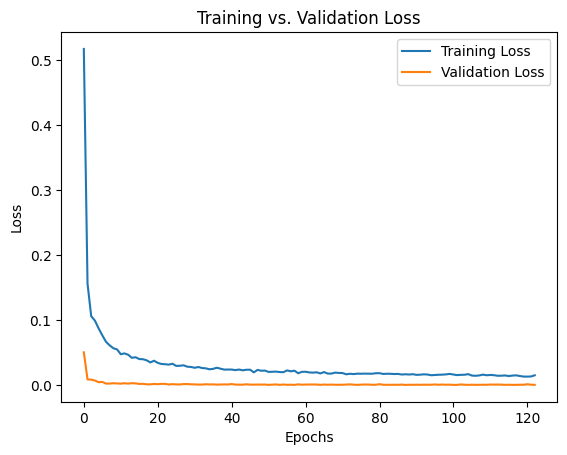

In [7]:
epochs = config.epochs
training_losses = []
validation_losses = []
checkpoint_counter = 0

#load model
#model = torch.load('results/CLR-2023-11-08-19-epochs-300-ADSMI/checkpoint.pth')
# Create log directory
current_date = datetime.datetime.now().strftime('%Y-%m-%d-%H')
log_dir = f"./results/CLR-{current_date}-epochs-{epochs}-{Data_name}-neu_V5"
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

# Log file path
log_file_path = os.path.join(log_dir, "training_log.txt")

#-write parameter in log file
with open(log_file_path, 'a') as log_file:
    log_file.write(f"Model: {model.__class__.__name__}\n")
    log_file.write(f"Batch size: {config.batch_size}\n")
    log_file.write(f"Learning rate: {config.lr}\n")
    log_file.write(f"Epochs: {epochs}\n")
    log_file.write(f"Patience: {patience}\n")
    log_file.write(f"Data: {Data_name}\n")
    log_file.write(f"Loss: {criterion.__class__.__name__}\n")
    log_file.write(f"Optimizer: {optimizer.__class__.__name__}\n")
    log_file.write(f"Scheduler: {lr_scheduler.__class__.__name__}\n")
    log_file.write(f"Device: {device}\n")



best_loss = float('inf')

# Training and Validation loop
for epoch in range(epochs):
    model.train()
    total_train_loss = 0.0

    for batch_idx, (anchor, positive, negative) in tqdm(enumerate(train_loader), total=len(train_loader)):
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)   
        optimizer.zero_grad()

        anchor_repr, positive_repr, negative_repr = model(anchor, positive, negative)
        
        #print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))
        loss = criterion(anchor_repr, positive_repr, negative_repr)
        loss.backward()

        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    training_losses.append(avg_train_loss)
    
    # Validation loop
    model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for batch_idx, (anchor, positive, negative) in tqdm(enumerate(test_loader), total=len(test_loader)):
            anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

            anchor_repr, positive_repr, negative_repr = model(anchor, positive, negative)
            loss = criterion(anchor_repr, positive_repr, negative_repr)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(test_loader)
    validation_losses.append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{epochs}] Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

    # Log to file
    with open(log_file_path, 'a') as log_file:
        log_file.write(f"Epoch [{epoch+1}/{epochs}] Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}\n")

    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        print("Validation Loss improved! Checkpointing the model...")
        torch.save(model, os.path.join(log_dir, f"checkpoint_{checkpoint_counter}.pth"))  # Modified this line
        with open(log_file_path, 'a') as log_file:
            log_file.write(f"Validation Loss improved at Epoch {epoch+1}.\n")
        early_stop_counter = 0  # reset counter
        checkpoint_counter += 1
    else:
        early_stop_counter += 1
        
    if early_stop_counter >= patience:
        print("Early stopping!")
        break

# Plot training and validation loss
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs. Validation Loss')
plt.show()


In [8]:
#spath = './results/CLR-2023-11-08-21-epochs-300-ADSMI/checkpoint_fullModel.pth'
#torch.save(model, spath)  
#save full model
torch.save(model, os.path.join(log_dir, f"checkpoint_fullModel.pth"))  # Modified this line

# Losses Plot

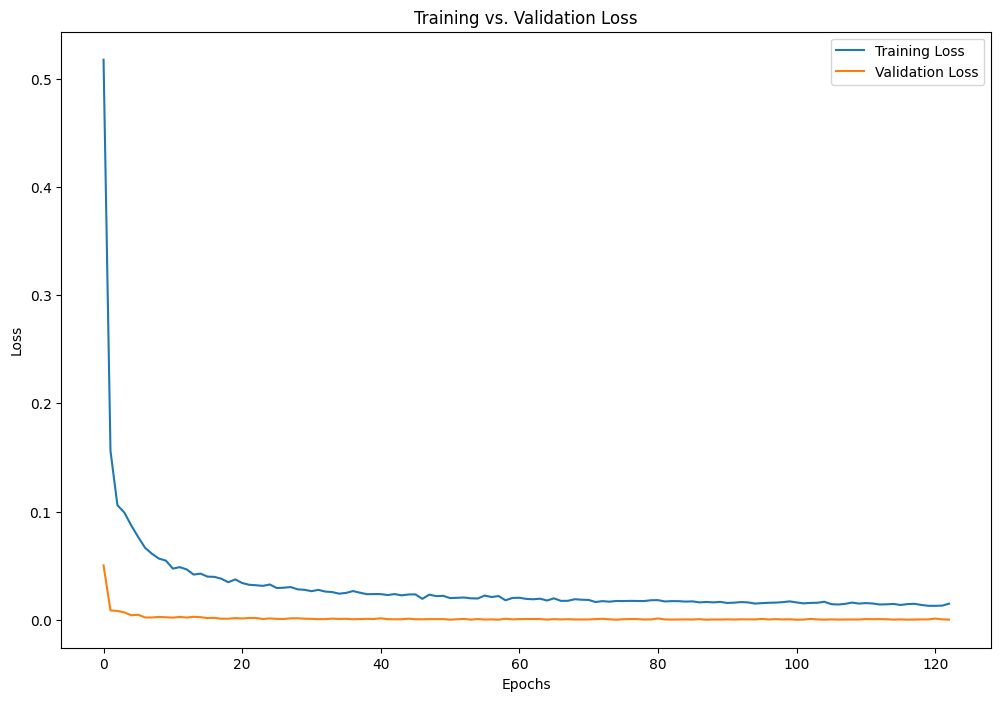

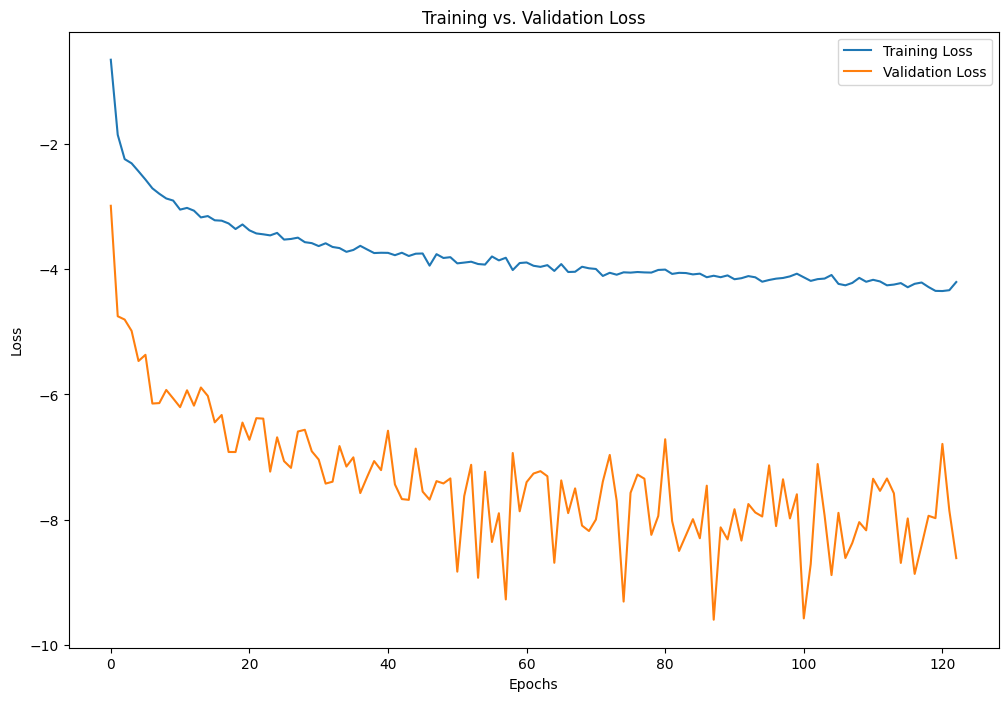

In [9]:
#plot train and validation loss
#logarithm the two losses
training_lossesl = np.log(training_losses)
validation_lossesl = np.log(validation_losses)

plt.figure(figsize=(12, 8))
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs. Validation Loss')
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(training_lossesl, label='Training Loss')
plt.plot(validation_lossesl, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs. Validation Loss')
plt.show()


